# GCNII実装

元論文：Simple and Deep Graph Convolutional Networks
Ming Chen, Zhewei Wei, Zengfeng Huang, Bolin Ding, Yaliang Li
ICML 2020

https://arxiv.org/abs/2007.02133
参考にしたコード：https://github.com/chennnM/GCNII

全体の流れ

0.   事前にcora.contentとcora.citesをダウンロードして/content/drive/My Drive/Colab Notebooks/に置いてください．
1.   ライブラリのインストール
2.   汎用関数の定義
3.   GCNIIモデル定義（深い層数でのIdentity mappingとSkip connection）
4.   グラフデータ読み込み
5.   学習準備
6.   モデル学習
7.   テスト精度検証
8.   結果の描画


# ライブラリのインストール

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import numpy as np
import scipy.sparse as sparse
import random as random
import os
import sys

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 汎用関数の定義

In [37]:
#乱数の固定化

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [38]:
def load_data():
    print("Loading Cora dataset...")
    raw_nodes_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.content', dtype="str")
    print(raw_nodes_data)
    raw_node_ids = raw_nodes_data[:, 0].astype('int32')  # 各行の一列目に格納されてるノードIDを抽出
    #print(raw_node_ids)
    raw_node_labels = raw_nodes_data[:, -1]# 各行の最終列に格納されてるラベルを抽出．このラベルが予測ターゲット
    #print(raw_node_labels)

    unique = list(set(raw_node_labels))
    #print(unique)
    labels_enumerated = np.array([unique.index(label) for label in raw_node_labels])
    #print(labels_enumerated)
    node_features = sparse.csr_matrix(raw_nodes_data[:, 1:-1], dtype="float32")
    #print(node_features)

    ids_ordered = {raw_id: order for order, raw_id in enumerate(raw_node_ids)} #実際のノードIDを0から節点数-1に対応付け
    #print(ids_ordered)
    raw_edges_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.cites', dtype="int32")
    #print(raw_edges_data)
    edges = np.array(list(map(ids_ordered.get, raw_edges_data.flatten())), dtype='int32').reshape(raw_edges_data.shape) # 実際のノードIDを変換. reshapeでデータ構造を元の枝ファイルと同様に変更．
    #print(edges)

    adj = sparse.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels_enumerated.shape[0], labels_enumerated.shape[0]),
                            dtype=np.float32)
    #print(adj)

    adj = adj + adj.T.multiply(adj.T > adj) #隣接行列を対象に変更 (つまり，無向グラフに変換)
    #print(adj)

    adj = adj + sparse.eye(adj.shape[0]) #対角成分に1を挿入

    node_degrees = np.array(adj.sum(1)) #列毎の総和を計算する（つまり，次数を計算する）
    #print(node_degrees)

    node_degrees = np.power(node_degrees, -0.5).flatten()
    #print(node_degrees)

    degree_matrix = sparse.diags(node_degrees, dtype=np.float32)
    print(degree_matrix)

    adj = degree_matrix @ adj @ degree_matrix #行列の積を計算．
    #torch.spmm(degree_matrix,torch.spmm(adj,degree_matrix))

    print(adj)

    features = torch.FloatTensor(node_features.toarray())
    labels = torch.LongTensor(labels_enumerated)
    adj = torch.FloatTensor(np.array(adj.todense()))

    return features, labels, adj, edges

In [39]:
def visualize_embedding_tSNE(labels, y_pred, num_classes):

    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    node_labels = labels.cpu().numpy()
    out_features = y_pred.detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                    t_sne_embeddings[node_labels == class_id, 1], s=20,
                    color=cora_label_to_color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("Visualizing t-SNE for GCNII")
    plt.show()

# GCNIIモデル定義

In [40]:
class GCNIILayer(nn.Module):
    """
    GCNII Layer implementation
    H^(l+1) = σ((1-α)P H^(l) W^(l) + α H^(0) W^(l))
    where P = D^(-1/2) A D^(-1/2) (normalized adjacency matrix)
    α: initial residual parameter
    λ: identity mapping parameter (used in weight initialization)
    """
    def __init__(self, in_features, out_features, layer_idx, total_layers, alpha, lamda, dropout):
        super(GCNIILayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.beta = np.log(lamda / layer_idx + 1)  # layer-dependent weight
        self.dropout = dropout

        # Linear transformation weight
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, adj, h0):
        """
        input: H^(l) - current layer input
        adj: normalized adjacency matrix
        h0: H^(0) - initial node features
        """
        # Apply dropout
        input = F.dropout(input, self.dropout, training=self.training)

        # Linear transformation: H^(l) W^(l)
        support = torch.mm(input, self.weight)

        # Graph convolution: P H^(l) W^(l)
        output = torch.mm(adj, support)

        # Initial residual connection: α H^(0) W^(l)
        initial_residual = torch.mm(h0, self.weight)

        # GCNII formula: (1-α)P H^(l) W^(l) + α H^(0) W^(l)
        output = (1 - self.alpha) * output + self.alpha * initial_residual

        # Identity mapping (skip connection from previous layer)
        # β controls the strength of identity mapping
        if self.in_features == self.out_features:
            output = output + self.beta * input

        return output


In [41]:
class GCNII(nn.Module):
    """
    GCNII Model: Simple and Deep Graph Convolutional Networks
    """
    def __init__(self, nfeat, nhid, nclass, nlayers, alpha, lamda, dropout):
        super(GCNII, self).__init__()
        self.nlayers = nlayers
        self.alpha = alpha
        self.lamda = lamda
        self.dropout = dropout

        # Initial feature transformation
        self.fcs = nn.ModuleList()
        self.fcs.append(nn.Linear(nfeat, nhid))

        # GCNII layers
        self.convs = nn.ModuleList()
        for i in range(nlayers):
            self.convs.append(GCNIILayer(nhid, nhid, i+1, nlayers, alpha, lamda, dropout))

        # Output layer
        self.fcs.append(nn.Linear(nhid, nclass))

        # Parameters for skip connections
        self.params1 = list(self.convs.parameters())
        self.params2 = list(self.fcs.parameters())

    def forward(self, x, adj):
        # Initial transformation
        h0 = x  # Store initial features
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.fcs[0](x))  # First linear layer with ReLU
        h0_transformed = x  # Transformed initial features for residual connections

        # GCNII layers with residual connections
        for i, conv in enumerate(self.convs):
            x = F.relu(conv(x, adj, h0_transformed))

        # Final dropout and classification
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.fcs[-1](x)  # Final linear layer

        return F.log_softmax(x, dim=1)

# グラフデータ読み込み

グラフ読み込み

In [42]:
features, labels, adj, edges = load_data()

Loading Cora dataset...
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]
<DIAgonal sparse matrix of dtype 'float32'
	with 2708 stored elements (1 diagonals) and shape (2708, 2708)>
  Coords	Values
  (0, 0)	0.40824830532073975
  (1, 1)	0.7071067690849304
  (2, 2)	0.4472135901451111
  (3, 3)	0.5
  (4, 4)	0.7071067690849304
  (5, 5)	0.5773502588272095
  (6, 6)	0.5773502588272095
  (7, 7)	0.7071067690849304
  (8, 8)	0.40824830532073975
  (9, 9)	0.4472135901451111
  (10, 10)	0.40824830532073975
  (11, 11)	0.5773502588272095
  (12, 12)	0.5773502588272095
  (13, 13)	0.5
  (14, 14)	0.22360679507255554
  (15, 15)	0.30151134729385376
  (16, 16)	0.4472135901451111
  (17, 17)	0.7071067690849304
  (18, 18)	0.3535533845424652
  (19, 19)	0.5773

In [43]:
print(features)
print(labels)
print(adj)
print(edges)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3, 0, 4,  ..., 6, 2, 3])
tensor([[0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500]])
[[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]]


# 学習準備

In [44]:
num_classes = int(labels.max().item() + 1)
train_size_per_class=20
validation_size=500
test_size=1000
classes = [ind for ind in range(num_classes)]
train_set = []

# Construct train set (indices) out of 20 samples per each class
for class_label in classes:
    target_indices = torch.nonzero(labels == class_label, as_tuple=False).tolist()
    train_set += [ind[0] for ind in target_indices[:train_size_per_class]]

# Extract the remaining samples
validation_test_set = [ind for ind in range(len(labels)) if ind not in train_set]
# Split the remaining samples into validation/test set
validation_set = validation_test_set[:validation_size]
test_set = validation_test_set[validation_size:validation_size+test_size]

In [45]:
# GCNIIのハイパーパラメータ（条件通り）
nlayers = 64        # 層数
hidden_dim = 64     # 隠れ層次元数
alpha = 0.2         # 初期残差パラメータ
lamda = 0.5         # スキップ接続パラメータ（λ）
dropout = 0.6       # ドロップアウト率

# GCNIIモデルを作成
model = GCNII(nfeat=features.shape[1],
             nhid=hidden_dim,
             nclass=num_classes,
             nlayers=nlayers,
             alpha=alpha,
             lamda=lamda,
             dropout=dropout)

print("=== GCNII Model ===")
print(model)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Number of layers: {nlayers}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Alpha (initial residual): {alpha}")
print(f"Lambda (identity mapping): {lamda}")
print(f"Dropout rate: {dropout}")

=== GCNII Model ===
GCNII(
  (fcs): ModuleList(
    (0): Linear(in_features=1433, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=7, bias=True)
  )
  (convs): ModuleList(
    (0-63): 64 x GCNIILayer()
  )
)
Model parameters: 354375
Number of layers: 64
Hidden dimension: 64
Alpha (initial residual): 0.2
Lambda (identity mapping): 0.5
Dropout rate: 0.6


In [46]:
if torch.cuda.is_available(): #cudaが使えるなら，GPUで処理
  model.cuda()
  adj = adj.cuda()
  features = features.cuda()
  labels = labels.cuda()
  print("Using GPU for training")
else:
  print("Using CPU for training")

# Adam最適化手法（条件通り）
# GCNII特有のパラメータ分離最適化
optimizer = torch.optim.Adam([
    {'params': model.params1, 'weight_decay': 5e-4},  # GCNII layers
    {'params': model.params2, 'weight_decay': 5e-4}   # Linear layers
], lr=0.001)

criterion = nn.NLLLoss()  # log_softmaxの後はNLLLossを使用


Using GPU for training


In [47]:
def accuracy(output, labels):
    y_pred = output.max(1)[1].type_as(labels)
    correct = y_pred.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# モデル学習

In [48]:
print("=== Training GCNII (PyTorch Geometric) ===")
validation_acc = []
validation_loss = []
training_acc=[]
training_loss=[]

# Early stopping設定（深いモデル用）
use_early_stopping = True
patience = 200  # 深いモデルなので忍耐強く

if use_early_stopping:
    best_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False

t_start = time.time()
maxepoch = 1500  # 深いモデルなのでより多くのエポックが必要
for epoch in range(maxepoch):
    optimizer.zero_grad()
    model.train()

    y_pred = model(features, adj)
    train_loss = criterion(y_pred[train_set], labels[train_set])
    train_acc = accuracy(y_pred[train_set], labels[train_set])
    train_loss.backward()
    optimizer.step()

    training_loss.append(train_loss.item())
    training_acc.append(train_acc)

    with torch.no_grad():
        model.eval()
        y_pred_val = model(features, adj)  # 評価時は新しく予測
        val_loss = criterion(y_pred_val[validation_set], labels[validation_set])
        val_acc = accuracy(y_pred_val[validation_set], labels[validation_set])

        validation_loss.append(val_loss.item())
        validation_acc.append(val_acc)

        if use_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    stopped_early = True
                    t_end = time.time()

    if epoch % 50 == 0: # 50エポック毎に出力（深いモデルなので）
      print(" | ".join([f"Epoch: {epoch:4d}", f"Train loss: {train_loss.item():.3f}",
                      f"Train acc: {train_acc:.3f}",
                      f"Val loss: {val_loss.item():.3f}",
                      f"Val acc: {val_acc:.3f}"]))

    if use_early_stopping and stopped_early:
        break

if use_early_stopping and stopped_early:
    print(f"EARLY STOPPING condition met. Stopped at epoch: {epoch}.")
else:
    t_end = time.time()

print(f"Total training time: {t_end-t_start:.2f} seconds")

=== Training GCNII (PyTorch Geometric) ===
Epoch:    0 | Train loss: 1.947 | Train acc: 0.143 | Val loss: 1.932 | Val acc: 0.132
Epoch:   50 | Train loss: 1.632 | Train acc: 0.571 | Val loss: 1.795 | Val acc: 0.382
Epoch:  100 | Train loss: 0.497 | Train acc: 0.886 | Val loss: 0.911 | Val acc: 0.728
Epoch:  150 | Train loss: 0.171 | Train acc: 0.964 | Val loss: 0.785 | Val acc: 0.780
Epoch:  200 | Train loss: 0.134 | Train acc: 0.979 | Val loss: 0.935 | Val acc: 0.746
Epoch:  250 | Train loss: 0.051 | Train acc: 1.000 | Val loss: 0.914 | Val acc: 0.780
Epoch:  300 | Train loss: 0.099 | Train acc: 0.986 | Val loss: 0.975 | Val acc: 0.780
EARLY STOPPING condition met. Stopped at epoch: 331.
Total training time: 27.51 seconds


# テスト精度の検証

In [49]:
print("=== Test Results (PyTorch Geometric) ===")
with torch.no_grad():
    model.eval()
    y_pred = model(features, adj)
    test_loss = criterion(y_pred[test_set], labels[test_set])
    test_acc = accuracy(y_pred[test_set], labels[test_set])

print(f"Test loss: {test_loss:.3f}  |  Test acc: {test_acc:.3f}")
print(f"Final Test Accuracy: {test_acc:.3f}")

=== Test Results (PyTorch Geometric) ===
Test loss: 0.906  |  Test acc: 0.785
Final Test Accuracy: 0.785


# 結果の描画

まずは，訓練データのロスと精度，開発データのロスと精度がエポック毎にどのように変化してるか見てみましょう．

=== Plotting Results ===


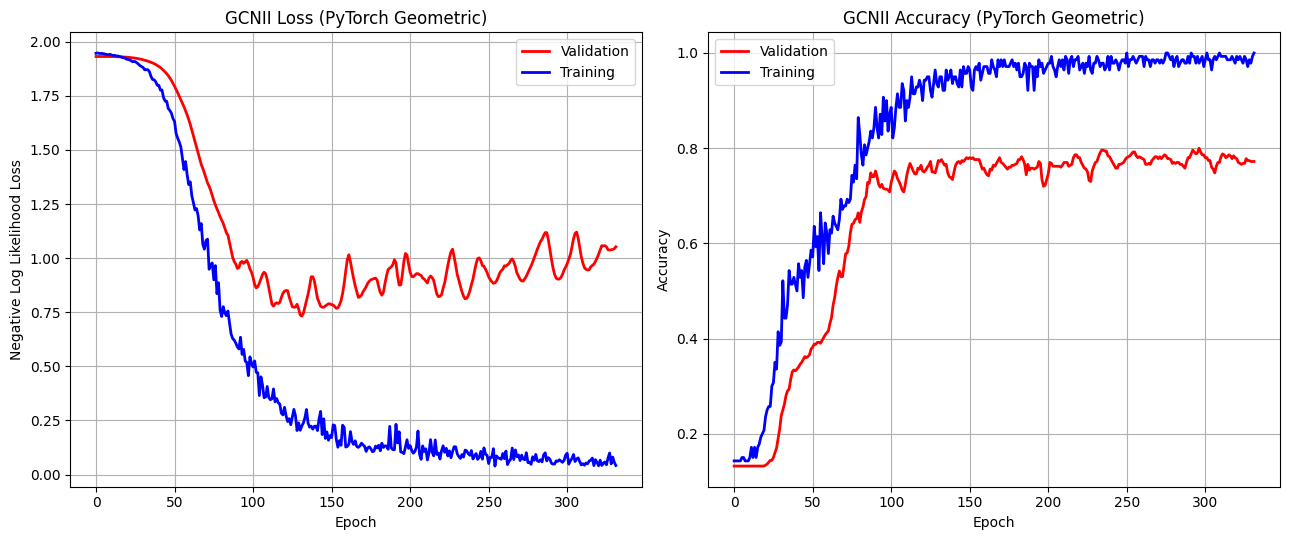

In [50]:
print("=== Plotting Results ===")
f, axs = plt.subplots(1, 2, figsize=(13, 5.5))
axs[0].plot(validation_loss, linewidth=2, color="red", label="Validation")
axs[0].plot(training_loss, linewidth=2, color="blue", label="Training")
axs[0].set_title("GCNII Loss (PyTorch Geometric)")
axs[0].set_ylabel("Negative Log Likelihood Loss")
axs[0].set_xlabel("Epoch")
axs[0].legend()
axs[0].grid()

# GPU tensorsをCPUに移してからplotting
validation_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in validation_acc]
training_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in training_acc]

axs[1].plot(validation_acc_cpu, linewidth=2, color="red", label="Validation")
axs[1].plot(training_acc_cpu, linewidth=2, color="blue", label="Training")
axs[1].set_title("GCNII Accuracy (PyTorch Geometric)")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

学習後のGCNII特徴表現がラベルごとにかたまっているか見てみましょう．
ここでは，tSNEを用いて多次元データを2次元に落とし込んで可視化をします．

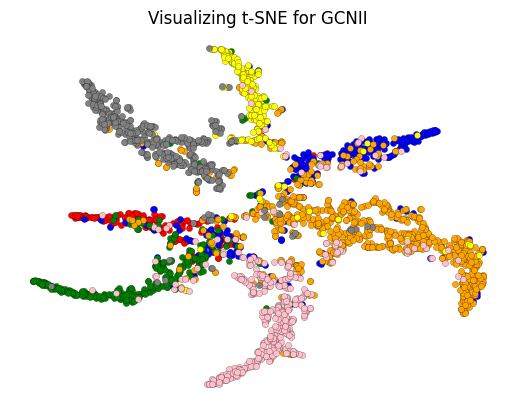

In [51]:
visualize_embedding_tSNE(labels, y_pred, num_classes)